In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Base SIM_DOFET

In [2]:
df_sim = pd.read_csv('./base_limpa/base_sim_dofet_limpa_remocao.csv')

In [16]:
df_sim_agreg_regiao = pd.DataFrame(
    df_sim.groupby(['cat_periodo_nasc', 'cat_peso_calc', 'ocor_REGIAO']).agg(Tamanho=('data_obito', 'size'))
).reset_index()

In [22]:
# Removendo covid e zika
df_sim_agreg_regiao_covid_zika = pd.DataFrame(
    df_sim[~df_sim['ano_obito'].isin([2015, 2017, 2020, 2021, 2022])].groupby(['cat_periodo_nasc', 'cat_peso_calc', 'ocor_REGIAO']).agg(Tamanho=('data_obito', 'size'))
).reset_index()

In [18]:
df_sim_agreg_brasil = pd.DataFrame(
    df_sim.groupby(['cat_periodo_nasc', 'cat_peso_calc']).agg(Tamanho=('data_obito', 'size'))
).reset_index()

In [23]:
# Removendo covid e zika
df_sim_agreg_brasil_covid_zika = pd.DataFrame(
    df_sim[~df_sim['ano_obito'].isin([2015, 2017, 2020, 2021, 2022])].groupby(['cat_periodo_nasc', 'cat_peso_calc']).agg(Tamanho=('data_obito', 'size'))
).reset_index()

In [25]:
del df_sim

# Base SINASC

In [26]:
df_sinasc = pd.read_csv('./base_limpa/base_sinasc_limpa_remocao.csv')

In [36]:
df_sinasc_agreg_regiao = pd.DataFrame(
    df_sinasc.groupby(['cat_periodo_nasc', 'cat_peso_calc', 'nasc_REGIAO']).agg(Tamanho=('data_nasc', 'size'))
).reset_index()

In [37]:
# Removendo covid e zika
df_sinasc_agreg_regiao_covid_zika = pd.DataFrame(
    df_sinasc[~df_sinasc['ano_nasc'].isin([2015, 2017, 2020, 2021, 2022])].groupby(['cat_periodo_nasc', 'cat_peso_calc', 'nasc_REGIAO']).agg(Tamanho=('data_nasc', 'size'))
).reset_index()

In [38]:
df_sinasc_agreg_brasil = pd.DataFrame(
    df_sinasc.groupby(['cat_periodo_nasc', 'cat_peso_calc']).agg(Tamanho=('data_nasc', 'size'))
).reset_index()

In [39]:
# Removendo covid e zika
df_sinasc_agreg_brasil_covid_zika = pd.DataFrame(
    df_sinasc[~df_sinasc['ano_nasc'].isin([2015, 2017, 2020, 2021, 2022])].groupby(['cat_periodo_nasc', 'cat_peso_calc']).agg(Tamanho=('data_nasc', 'size'))
).reset_index()

In [40]:
del df_sinasc

# Cálculos todos os anos 

In [45]:
def calculate_rr(df_obito, df_nasc, region=None):
    if region:
        df_obito = df_obito[df_obito['ocor_REGIAO'] == region].reset_index(drop=True)
        df_nasc = df_nasc[df_nasc['nasc_REGIAO'] == region].reset_index(drop=True)
    
    df_obito['group'] = 'Termo_AIG'
    df_obito.loc[(df_obito['cat_periodo_nasc'] == 'termo') & (df_obito['cat_peso_calc'] == 'PIG'), 'group'] = 'Termo_PIG'
    df_obito.loc[(df_obito['cat_periodo_nasc'] == 'pre_termo') & (df_obito['cat_peso_calc'] == 'AIG'), 'group'] = 'Pre_Termo_AIG'
    df_obito.loc[(df_obito['cat_periodo_nasc'] == 'pre_termo') & (df_obito['cat_peso_calc'] == 'PIG'), 'group'] = 'Pre_Termo_PIG'
    df_obito.loc[(df_obito['cat_periodo_nasc'] == 'termo') & (df_obito['cat_peso_calc'] == 'GIG'), 'group'] = 'Termo_GIG'
    df_obito.loc[(df_obito['cat_periodo_nasc'] == 'pre_termo') & (df_obito['cat_peso_calc'] == 'GIG'), 'group'] = 'Pre_Termo_GIG'
    
    df_nasc['group'] = 'Termo_AIG'
    df_nasc.loc[(df_nasc['cat_periodo_nasc'] == 'termo') & (df_nasc['cat_peso_calc'] == 'PIG'), 'group'] = 'Termo_PIG'
    df_nasc.loc[(df_nasc['cat_periodo_nasc'] == 'pre_termo') & (df_nasc['cat_peso_calc'] == 'AIG'), 'group'] = 'Pre_Termo_AIG'
    df_nasc.loc[(df_nasc['cat_periodo_nasc'] == 'pre_termo') & (df_nasc['cat_peso_calc'] == 'PIG'), 'group'] = 'Pre_Termo_PIG'
    df_nasc.loc[(df_nasc['cat_periodo_nasc'] == 'termo') & (df_nasc['cat_peso_calc'] == 'GIG'), 'group'] = 'Termo_GIG'
    df_nasc.loc[(df_nasc['cat_periodo_nasc'] == 'pre_termo') & (df_nasc['cat_peso_calc'] == 'GIG'), 'group'] = 'Pre_Termo_GIG'
    
    deaths = df_obito.groupby('group')['Tamanho'].sum()
    births = df_nasc.groupby('group')['Tamanho'].sum()
    
    rr_results = []
    comparisons = [
        ('Termo_AIG', 'Termo_PIG'),
        ('Termo_AIG', 'Pre_Termo_AIG'),
        ('Termo_AIG', 'Pre_Termo_PIG'),
        ('Termo_AIG', 'Termo_GIG'),
        ('Termo_AIG', 'Pre_Termo_GIG')
    ]
    
    for ref, exp in comparisons:
        if ref in deaths and exp in deaths and ref in births and exp in births:
            rate_exp = deaths[exp] / births[exp]
            rate_ref = deaths[ref] / births[ref]
            rr = rate_exp / rate_ref
            
            ci_lower = rr * np.exp(-1.96 * np.sqrt((1/deaths[exp]) + (1/deaths[ref])))
            ci_upper = rr * np.exp(1.96 * np.sqrt((1/deaths[exp]) + (1/deaths[ref])))
            
            rr_results.append({
                'Region': region if region else 'Brasil',
                'Comparison': f'{exp} vs {ref}',
                'RR': round(rr, 2),
                'CI Lower': round(ci_lower, 2),
                'CI Upper': round(ci_upper, 2)
            })
    
    return pd.DataFrame(rr_results)


In [46]:
df_brasil_geral = calculate_rr(df_obito=df_sim_agreg_brasil, df_nasc=df_sinasc_agreg_brasil)
# Exibindo os resultados
display(df_brasil_geral)

,Region,Comparison,RR,CI Lower,CI Upper
0,Brasil,Termo_PIG vs Termo_AIG,3.74,3.67,3.81
1,Brasil,Pre_Termo_AIG vs Termo_AIG,24.90,24.53,25.28
2,Brasil,Pre_Termo_PIG vs Termo_AIG,77.36,76.24,78.49
3,Brasil,Termo_GIG vs Termo_AIG,2.21,2.15,2.27
4,Brasil,Pre_Termo_GIG vs Termo_AIG,19.60,19.26,19.94


In [50]:
df_regioes_geral = pd.concat([calculate_rr(df_obito=df_sim_agreg_regiao, df_nasc=df_sinasc_agreg_regiao, region=region) for region in df_sim_agreg_regiao['ocor_REGIAO'].unique()])
display(df_regioes_geral)

,Region,Comparison,RR,CI Lower,CI Upper
0,Centro-Oeste,Termo_PIG vs Termo_AIG,3.82,3.58,4.08
1,Centro-Oeste,Pre_Termo_AIG vs Termo_AIG,27.56,26.13,29.07
2,Centro-Oeste,Pre_Termo_PIG vs Termo_AIG,89.36,84.86,94.10
3,Centro-Oeste,Termo_GIG vs Termo_AIG,2.37,2.16,2.61
4,Centro-Oeste,Pre_Termo_GIG vs Termo_AIG,22.61,21.28,24.03
0,Nordeste,Termo_PIG vs Termo_AIG,3.70,3.59,3.81
1,Nordeste,Pre_Termo_AIG vs Termo_AIG,21.83,21.28,22.40
2,Nordeste,Pre_Termo_PIG vs Termo_AIG,69.21,67.53,70.93
3,Nordeste,Termo_GIG vs Termo_AIG,2.20,2.11,2.30
4,Nordeste,Pre_Termo_GIG vs Termo_AIG,13.32,12.93,13.71


In [53]:
df_brasil_geral.to_csv('resultado/rr_obitos_c_nasc_brasil.csv', index=False)
df_regioes_geral.to_csv('resultado/rr_obitos_c_nasc_regiao.csv', index=False)

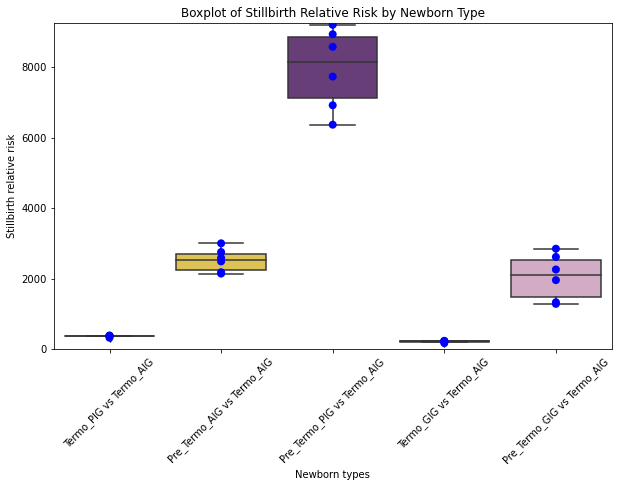

In [60]:
df_graf_geral = pd.concat([df_regioes_geral, df_brasil_geral])
df_graf_geral['RR_100'] = df_graf_geral['RR']*100

# Criar o boxplot
plt.figure(figsize=(10, 6))  # Aumentar tamanho do gráfico
ax = sns.boxplot(x="Comparison", y="RR_100", data=df_graf_geral, palette=["#D8A4C8", "#F4D03F", "#6C3483", "#1F618D"])

# Adicionar pontos médios
sns.stripplot(x="Comparison", y="RR_100", data=df_graf_geral, color="blue", size=8, jitter=False)

# Adicionar rótulos dos valores
# for i, value in enumerate(df_graf["RR_100"]):
#     plt.text(i, value + 5, f"{value:.1f}", ha='center', fontsize=10, fontweight='bold')

# Configurações do gráfico
plt.ylabel("Stillbirth relative risk")
plt.xlabel("Newborn types")
plt.ylim(0, max(df_graf_geral["RR_100"]) + 50)  # Ajustar limite superior
plt.xticks(rotation=45)
plt.title("Boxplot of Stillbirth Relative Risk by Newborn Type")

# Mostrar o gráfico
plt.show()

# Cálculo ZIKA e COVID

In [58]:
df_brasil_covid_zika = calculate_rr(df_obito=df_sim_agreg_brasil_covid_zika, df_nasc=df_sinasc_agreg_brasil_covid_zika)
# Exibindo os resultados
display(df_brasil_covid_zika)

,Region,Comparison,RR,CI Lower,CI Upper
0,Brasil,Termo_PIG vs Termo_AIG,3.72,3.63,3.82
1,Brasil,Pre_Termo_AIG vs Termo_AIG,24.43,23.91,24.95
2,Brasil,Pre_Termo_PIG vs Termo_AIG,75.68,74.15,77.25
3,Brasil,Termo_GIG vs Termo_AIG,2.25,2.17,2.33
4,Brasil,Pre_Termo_GIG vs Termo_AIG,19.01,18.55,19.47


In [54]:
df_regioes_covid_zika = pd.concat([calculate_rr(df_obito=df_sim_agreg_regiao_covid_zika, df_nasc=df_sinasc_agreg_regiao_covid_zika, region=region) for region in df_sim_agreg_regiao['ocor_REGIAO'].unique()])
display(df_regioes_covid_zika)

,Region,Comparison,RR,CI Lower,CI Upper
0,Centro-Oeste,Termo_PIG vs Termo_AIG,3.87,3.53,4.25
1,Centro-Oeste,Pre_Termo_AIG vs Termo_AIG,27.49,25.49,29.65
2,Centro-Oeste,Pre_Termo_PIG vs Termo_AIG,86.47,80.33,93.07
3,Centro-Oeste,Termo_GIG vs Termo_AIG,2.42,2.12,2.77
4,Centro-Oeste,Pre_Termo_GIG vs Termo_AIG,21.56,19.79,23.49
0,Nordeste,Termo_PIG vs Termo_AIG,3.68,3.53,3.83
1,Nordeste,Pre_Termo_AIG vs Termo_AIG,21.63,20.86,22.42
2,Nordeste,Pre_Termo_PIG vs Termo_AIG,67.82,65.51,70.21
3,Nordeste,Termo_GIG vs Termo_AIG,2.19,2.07,2.33
4,Nordeste,Pre_Termo_GIG vs Termo_AIG,13.11,12.58,13.65


In [59]:
df_brasil_covid_zika.to_csv('resultado/rr_obitos_c_nasc_brasil_covid_zika.csv', index=False)
df_regioes_covid_zika.to_csv('resultado/rr_obitos_c_nasc_regiao_covid_zika.csv', index=False)

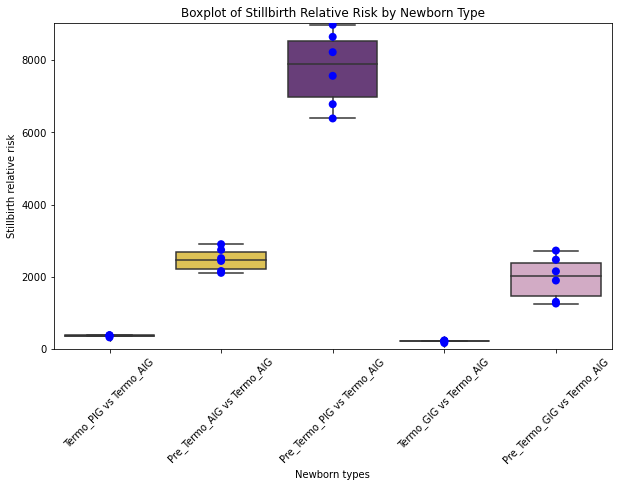

In [62]:
df_graf_covid_zika = pd.concat([df_regioes_covid_zika, df_brasil_covid_zika])
df_graf_covid_zika['RR_100'] = df_graf_covid_zika['RR']*100

# Criar o boxplot
plt.figure(figsize=(10, 6))  # Aumentar tamanho do gráfico
ax = sns.boxplot(x="Comparison", y="RR_100", data=df_graf_covid_zika, palette=["#D8A4C8", "#F4D03F", "#6C3483", "#1F618D"])

# Adicionar pontos médios
sns.stripplot(x="Comparison", y="RR_100", data=df_graf_covid_zika, color="blue", size=8, jitter=False)

# Adicionar rótulos dos valores
# for i, value in enumerate(df_graf["RR_100"]):
#     plt.text(i, value + 5, f"{value:.1f}", ha='center', fontsize=10, fontweight='bold')

# Configurações do gráfico
plt.ylabel("Stillbirth relative risk")
plt.xlabel("Newborn types")
plt.ylim(0, max(df_graf_covid_zika["RR_100"]) + 50)  # Ajustar limite superior
plt.xticks(rotation=45)
plt.title("Boxplot of Stillbirth Relative Risk by Newborn Type")

# Mostrar o gráfico
plt.show()